In [1]:
%autosave 0

Autosave disabled


# Introduction

This project explores predicting sonic logs (MDT) for a given oil well based on already logged data. The primary aim was to determine how accurately logs from a well in given block could predict the sonic log for another well either in the same block or in a different block. Based on the function of sonic logs in well logging, the following logs – Potassium (POTA), GammaRay(GR), NeutronPorosity(NPHI),   Resistivity (LLD), Density(RHOB), Uranium (URAN), Thromium(TH)   were used to build 8 models – Linear Regression, Partial Least Squares, Extreme Gradient Boosted Trees, Extreme Gradient Boosted Linear Models
Of the models the Extreme Gradient Boosted Trees performed the best on the same well RMSE is 2.7 and on a different well in a different block was 8.17

## Methodology

The process builds models from oilwell log located in the Midland Basin - Block 5, Section 35.
First exploratory data analysis was carried out, the machine learning models where then built using cross validation. To test another oilwell log from Block 5, section 16 was used to test.
Next outliers where taken out, models where rebuilt again and tested, this both with outliers and without outliers in the test dataset.

# Data Preparation

Python has a well developed library LASIO for reading the well log (.las) files. The LASIO library was used to extract the logs into a pandas dataframe that could then be explored and utilized for model building. 
The same process is used for the test dataframe

In [1]:
import lasio as la
import numpy as np
import pandas as pd

### View the log description

In [2]:
las = la.read(r'4200341370.las')
print(las.curves)

Mnemonic  Unit  Value           Description       
--------  ----  -----           -----------       
DEPT      F     00 000 000 000  Depth             
GRTO      api   00 000 000 000  GammaTotal        
GRKT      api   00 000 000 000  GammaKT           
GRTH      api   00 000 000 000  GammaTh           
GKUT      api   00 000 000 000  GammaKUT          
POTA      %     00 000 000 000  Potassium         
URAN      ppm   00 000 000 000  Uranium           
THOR      ppm   00 000 000 000  Thorium           
MSFL      ohmm  00 000 000 000  MSFL              
LLS       ohmm  00 000 000 000  LLS               
LLD       ohmm  00 000 000 000  LLD               
GR        api   00 000 000 000  Gamma API         
CALI      in    00 000 000 000  Caliper           
BHVT      ft3   00 000 000 000  Borehole Volume   
AHVT      ft3   00 000 000 000  Annular Volume    
RHOB      g/cc  00 000 000 000  Density           
DRHO      g/cc  00 000 000 000  DensityCorr       
PE        b/e   00 000 000 000 

In [49]:
las.params

[HeaderItem(mnemonic=DCS, unit=, value=03-May-10, descr=DateCircEndT),
 HeaderItem(mnemonic=TCS, unit=, value=12 09, descr=Time Ciculation Ended),
 HeaderItem(mnemonic=DLAB, unit=, value=03-May-10, descr=LogStartDateT),
 HeaderItem(mnemonic=TLAB:1, unit=, value=12 09, descr=LogStartTimeT),
 HeaderItem(mnemonic=DATE, unit=, value=03-May-10, descr=Run Date),
 HeaderItem(mnemonic=TDCE, unit=ucts, value=12.09.36 03-May-10, descr=Time Ci...),
 HeaderItem(mnemonic=TLAB:2, unit=ucts, value=12.09.36 03-May-10, descr=Log S...)]

In [3]:
train = pd.DataFrame(las.data, columns=list(las.curvesdict.keys()))

#Drop missing values - sometimes the calibration tools malfunction and do not read the values
train.dropna(axis=0,how='any',inplace=True)
train.shape

(13020, 29)

### Import the data frame

### Extract Second Well Log For Test

In [4]:
las2 = la.read(r'4200340497.las')
test = pd.DataFrame(las2.data, columns=list(las.curvesdict.keys()))
test.dropna(axis=0,how='any',inplace=True)
test.shape

(13428, 29)

## Exploratory Data Analysis

Based on petroleum engineering log literature the following logs will be dropped:\
CALI & TENS are tool calibration (this will be dropped after confirmation that there is no washout) and tension logs\
DRHO, XPHI, SPHI, DPHI, NDSN, FDSN, ITTT are calculated from the recorded logs\
MSFL and LLS are resistivity logs but LLD will be used since it records resisitivity in an uninvaded formation \
AHVT measures the volume of the well where cement is to be poured\
GRTO, GRTH , GRKT, and GKUT are various gamma rays because GKUT and GRTO measure the same thing and GKUT is not available in a lot of logs\

The variable to be predicted is MDT - mono delta t\
Some of the variables like the resistivity logs have a very spread out distribution, for example LLD is heavily right skewed\

### Checking Data For Washout

Washout occurs when the rock formation is much wider than the hole originaly bored by the tool. An effect of washout is that the caliper tool reads data from mud or water. One way to confirm there is washout is to confirm that the caliper readings are not more than 1.5 times larger than what was set.
From the summary below, it was determined that there was washout because the caliper had a maximum reading of 22.411600\

In [5]:
# CALI - caliper log will be used to determine washout then dropped
train.drop(columns = ['TENS','DRHO','XPHI','SPHI','DPHI','NDSN','FDSN','ITTT','MSFL','LLS','AHVT','GRTO','GRTH','GRKT','GKUT','DXDT','DYDT'], inplace=True)
train.describe()

,DEPT,POTA,URAN,THOR,LLD,GR,CALI,BHVT,RHOB,PE,NPHI,MDT
count,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000
mean,7821.117281,1.406437,3.387219,4.632478,864.000566,66.415054,8.449059,1262.640400,2.573042,3.431235,0.144308,67.293916
std,1884.012138,0.765648,2.087910,2.851356,4044.583167,34.561351,0.499220,730.571224,0.130893,0.805665,0.072319,10.904100
min,4475.000000,0.040500,0.129900,0.113000,0.044500,2.713600,6.647000,41.589200,1.002800,1.208900,-0.012600,41.114400
25%,6191.375000,0.672200,1.758550,2.002425,19.972025,37.579275,8.160600,629.894575,2.494000,2.850375,0.083300,58.393925
50%,7818.750000,1.571650,2.921950,4.539300,66.606950,62.908400,8.269100,1233.866100,2.563500,3.258250,0.154800,69.568250
75%,9449.125000,1.983675,4.789150,6.890750,205.622875,93.816950,8.644925,1891.929100,2.641225,3.956850,0.192100,74.593125
max,11089.500000,4.021900,22.411600,14.421400,40000.000000,258.443600,22.016100,2747.968300,2.997100,9.677000,0.856700,181.575800


## Exploratory Analysis

The train dataset will be utilized for analysis afterwhich it will be dropped.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

###  Variable Distribution - Histograms

#### Histograms For The Whole Data

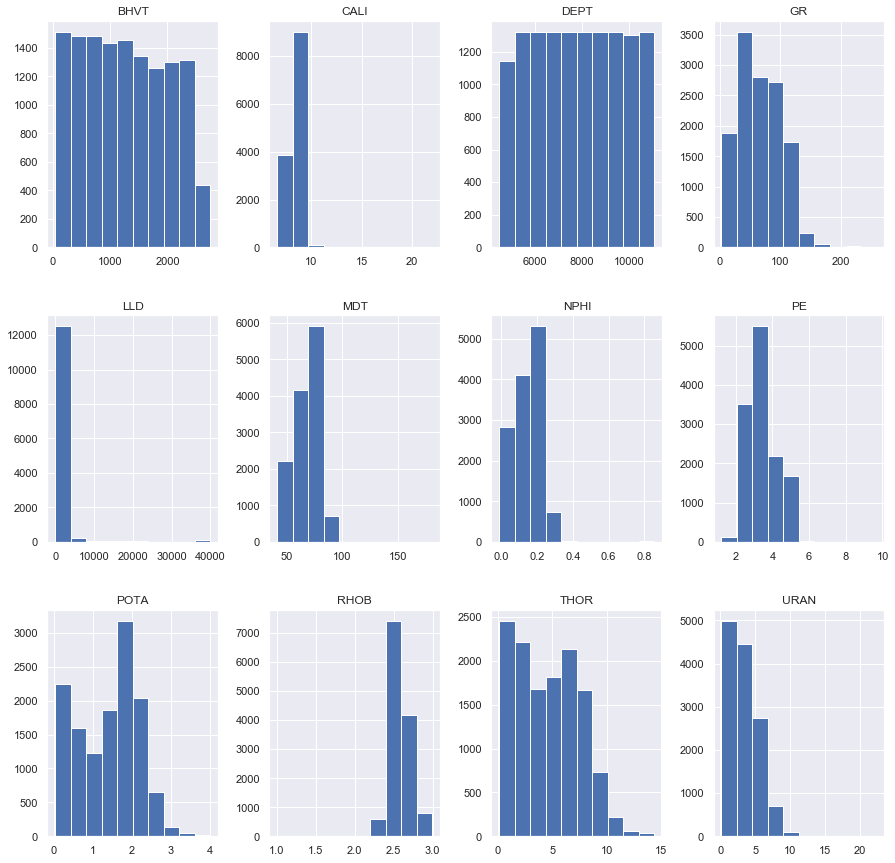

In [7]:
train.hist(bins=10,figsize=(15, 15), layout=(3, 4))
plt.show()

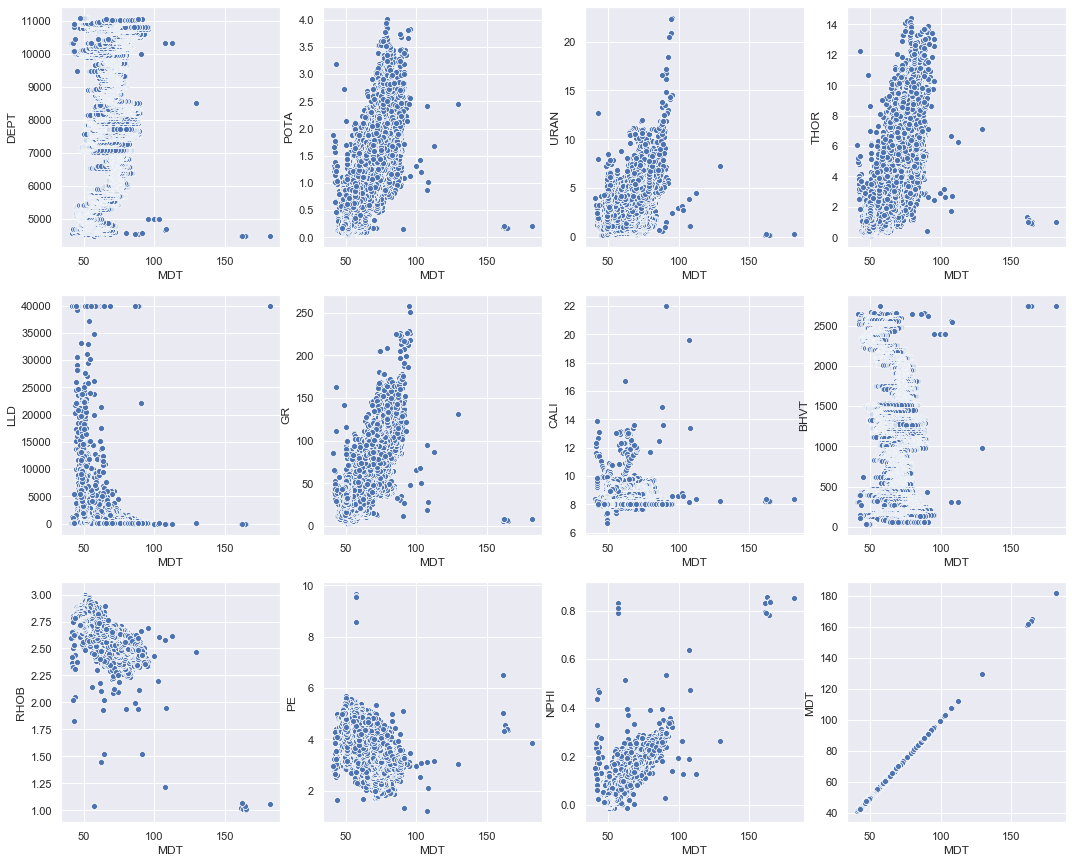

In [12]:
names = train.columns
fig, ax = plt.subplots(3, 4, figsize=(18, 15))
for variable, subplot in zip(names, ax.flatten()):
    sns.scatterplot(train['MDT'],train[variable], ax=subplot)
    

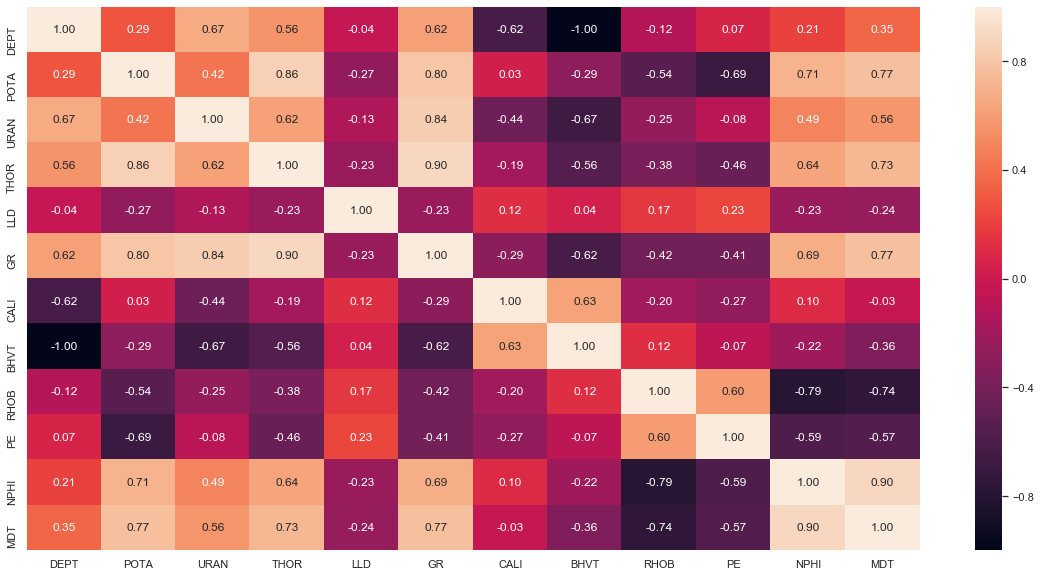

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(train.corr(),annot=True, fmt='0.2f', ax=ax);


Determining the relationship between the predictors and the Sonic log variable
Well Depth and Volume dont appear to have linear relationship with the Sonic Log and because they are highly collinear Volume will be dropped because logic would dictate that values might change as depth increases.
The univariate distribution of resistivity is heavily skewed, and so its relationship with Sonic Log is unclear. The relationship appears to be non-linear.
The rest have a clear linear relationship: Postassim, Uranium, Thromuim, Gamma Ray and Neutron Porosity have a positive relationship and Density and Photo Electric logs have a negative linear relationship with Sonic Log

Resistivity, uranium and gamma ray have skewed data and need to be transformed. First skewness will be tested, and all skewed features will be transformed utilizing Box-Cox transformation
To ensure that no feature is more influential than another due to its values, min-max scaling will be utilized if necessary on features that where not previously Power transformed.

### Skewness Test & Data Transformation

The test for skewness on the complete data showed that Resitivity , Neutron Porosity, Uranium, Photoelectric, GammaRay,Thromium and RHOB all have skewness.\
As such they need to be transformed for normality, NPHI has negative values and so a Yeo-Johnson transformation is performed, Box-Cox is utilized for the rest.\
Also Depth has values that are extremely larger than all the other values and so Min-Max scaler is used to constrain the values to a range between 0 and 1.\
Potassium is not transformed because it does not have noticable skew and the values are not excessively large.\


In [6]:
from scipy.stats import skew
train.drop(columns = 'BHVT', inplace=True)
train.apply(lambda x: skew(x)).sort_values(ascending=False)

LLD     8.032503
CALI    5.767533
URAN    1.103542
NPHI    0.704537
PE      0.630133
GR      0.415345
THOR    0.315809
MDT     0.269944
DEPT    0.002116
POTA   -0.076621
RHOB   -1.301133
dtype: float64

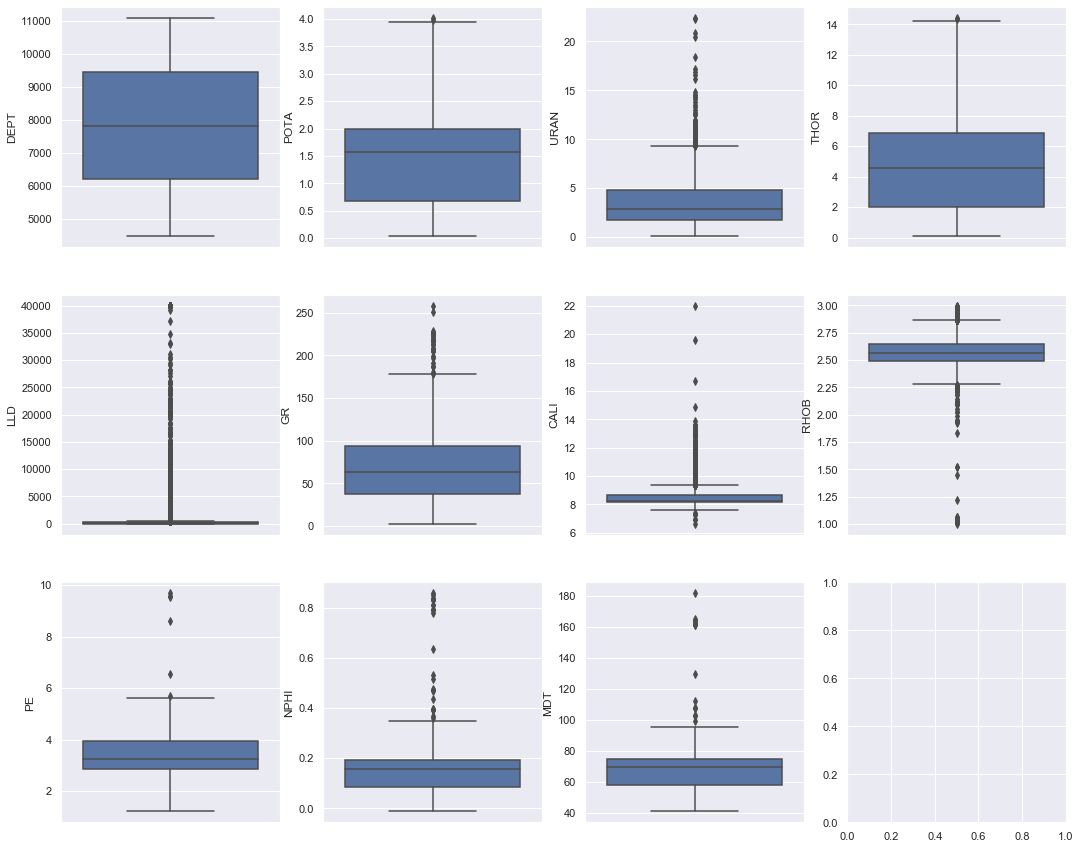

In [9]:
names = train.columns
fig, ax = plt.subplots(3,4, figsize=(18, 15))
for variable, subplot in zip(names, ax.flatten()):
    b = sns.boxplot(train[variable], orient = "v", ax=subplot)

## Data Modelling

Since outliers are suspected, observations were dropped using the difference between the observed caliper measurement in the logs and 7.88 which was the set measure for the caliper. '

Three data sets with the following labels listed below will be created

 * x_all & y_all - original dataset
 * x_small & y_small - dataset with only caliper outliers dropped
 * x_no_out & y_no_out - dataset outliers from all logs dropped

Next the data is then split into the y variable MDT and the independent variables which is all the other variables.

In [8]:
det = train.describe()

iqr_dict = dict()
for col in det.columns:
    Q1 = det.loc['25%',col]
    Q3 = det.loc['75%',col]
    iqr = Q3 - Q1
    low = Q1 - (1.5 * iqr)
    up = Q3 + (1.5 * iqr)
    iqr_dict.update({col:[low,up]})

iqr_dict


{'DEPT': [1304.75, 14335.75],
 'POTA': [-1.2950125000000003, 3.9508875000000003],
 'URAN': [-2.7873500000000004, 9.33505],
 'THOR': [-5.3300625, 14.2232375],
 'LLD': [-258.50424999999996, 484.09915],
 'GR': [-46.77723750000001, 178.17346250000003],
 'CALI': [7.4341125, 9.371412500000002],
 'RHOB': [2.2731624999999998, 2.8620625000000004],
 'PE': [1.1906624999999988, 5.616562500000001],
 'NPHI': [-0.07989999999999998, 0.35529999999999995],
 'MDT': [34.09512499999999, 98.89192500000001]}

In [9]:
#Get 25th and 75th Percentiles
    
#Function to drop outliers
def drop_outliers(df,iqr_dict,col):
    if col == 0:
        df = df[(df['CALI'] >= iqr_dict['CALI'][0]) & (df['CALI'] <= iqr_dict['CALI'][1])]
        return df
    else:
        for key in iqr_dict:
            df = df[(df[key] >= iqr_dict[key][0]) & (df[key] <= iqr_dict[key][1])]
        return df

df_small = drop_outliers(train,iqr_dict,0)
df_no_out = drop_outliers(train,iqr_dict,1)

print("Shape of dataframe with caliper outliers removed:", df_small.shape)
print("Shape of dataframe with all log outliers removed:", df_no_out.shape)

Shape of dataframe with caliper outliers removed: (12673, 11)
Shape of dataframe with caliper outliers removed: (10360, 11)


In [10]:
#Function To Drop Outliers and Split the Data
def split_df(df):    
    #Split the data
    x_split = pd.DataFrame(df[['URAN', 'THOR', 'LLD', 'GR', 'RHOB', 'PE','NPHI','DEPT']])
    y_split = df.loc[:,'MDT']
    return x_split,y_split


x_all, y_all = split_df(train)
x_small, y_small = split_df(df_small)
x_no_out, y_no_out = split_df(df_no_out)


Boxplots to veiw the effect of dropping observations

In [11]:
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

#Box-Cox Transformation of Skewed Variables with Only Positive Values 
col_trans = make_column_transformer(
                                    (PowerTransformer(),['URAN', 'THOR', 'LLD', 'GR', 'RHOB', 'PE']),
                                    (PowerTransformer(method='yeo-johnson'),['NPHI']),
                                    (MinMaxScaler(),['DEPT'])
                                    )
x_all = col_trans.fit_transform(x_all)
x_small = col_trans.fit_transform(x_small)
x_no_out = col_trans.fit_transform(x_no_out)


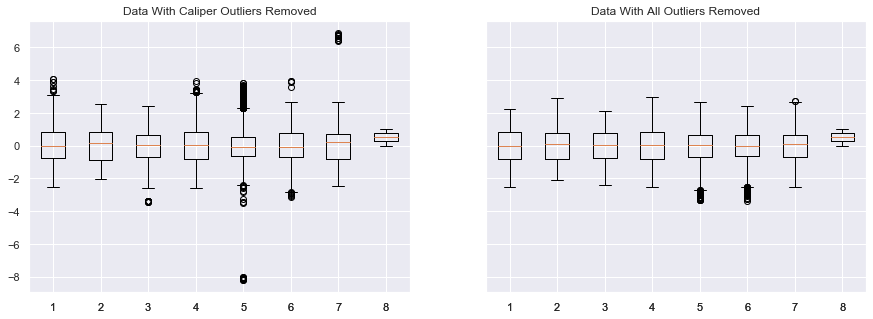

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True,sharey=True,figsize=(15, 5))
ax1.set_title("Data With Caliper Outliers Removed",loc='center')
ax1.boxplot(x_small);

ax2.set_title("Data With All Outliers Removed",loc='center')
ax2.boxplot(x_no_out);

### Modelling

As seen above, the variables still have outliers as such the models utilized need to be robust to outliers
The following models will be utilzed and compared using their mean absolute error:
    * Simple Models: Linear Regression, Elastic Net
    * Stacking: Linear Regression, Elastic Net and Random Forest
    * Neural Network

In [51]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.base import clone

lin_reg1 = LinearRegression()
lin_reg2 = clone(lin_reg1)
lin_reg3 = clone(lin_reg1)


lin_reg_cv1 = cross_validate(lin_reg1, x_all, y_all, scoring='neg_mean_absolute_error',return_train_score=True, cv =5)
lin_reg_cv2 = cross_validate(lin_reg2, x_small, y_small, scoring= 'neg_mean_absolute_error',return_train_score=True, cv =5)
lin_reg_cv3 = cross_validate(lin_reg3, x_no_out, y_no_out, scoring='neg_mean_absolute_error',return_train_score=True, cv =5)

report_table = [[lin_reg_cv1['train_score'].mean(),lin_reg_cv1['test_score'].mean()]]
report_table = report_table + [[lin_reg_cv2['train_score'].mean() ,lin_reg_cv2['test_score'].mean()]]
report_table = report_table + [[lin_reg_cv3['train_score'].mean(),lin_reg_cv3['test_score'].mean()]]

report = pd.DataFrame(report_table,columns = ['LR_CV Train MAE',' LR_CV Test MAE'],index=['all data','no caliper outliers','no_outliers'])
report

,LR_CV Train MAE,LR_CV Test MAE
all data,-2.396692,-3.069166
no caliper outliers,-2.250265,-2.819895
no_outliers,-1.990051,-2.508445


A comparison of error from this dataset would indicate that the x_no_out dataset (which is the dataset with outliers that have caliper difference +-1 ) is the better choice. Dropping the outliers has a positive impact on the results of the three datasets.
Training will still be done with all and then a final choice will be made.

### Lasso Regression

The lasso 

In [34]:
#from sklearn.linear_model import Lasso
#from sklearn.model_selection import GridSearchCV
#from sklearn.base import clone

lasso = Lasso()

alpha_range = list(np.linspace(0.01,0.1,20))
param_grid = dict(alpha=alpha_range)

lasso_reg1 = GridSearchCV(lasso,param_grid,scoring = 'neg_mean_absolute_error',refit=True,cv = 5,return_train_score= True ,verbose = 1)
lasso_reg2 = clone(lasso_reg1)
lasso_reg3 = clone(lasso_reg1)

lasso_reg1.fit(x_all, y_all)
results_lasso_all = pd.DataFrame(lasso_reg1.cv_results_)

lasso_reg2.fit(x_small, y_small)
results_lasso_small = pd.DataFrame(lasso_reg2.cv_results_)

lasso_reg3.fit(x_no_out, y_no_out)
results_lasso_no_out = pd.DataFrame(lasso_reg3.cv_results_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


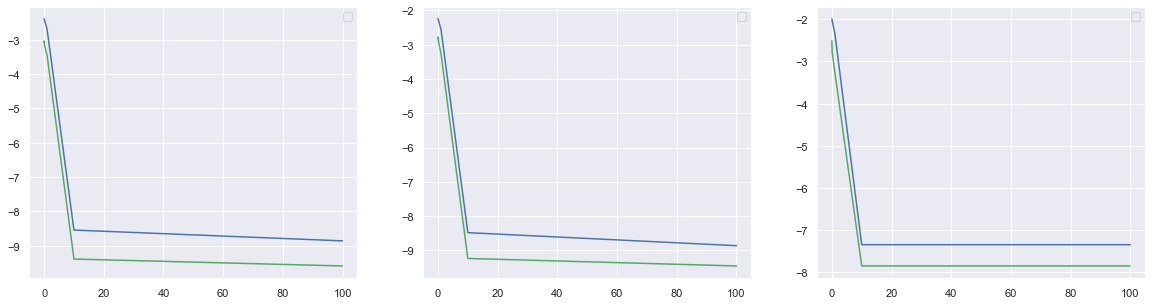

In [25]:
#Plot scores

def plot(ax,alpha_list, mean_train_score, mean_test_score):
    ax.plot(alpha_list, mean_train_score, c = 'b')
    ax.plot(alpha_list, mean_test_score, c = 'g')
    ax.legend(loc = 1)
    return

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20, 5))
plot(ax1,results_lasso_all.param_alpha, results_lasso_all.mean_train_score, results_lasso_all.mean_test_score)
plot(ax2,results_lasso_small.param_alpha, results_lasso_small.mean_train_score, results_lasso_small.mean_test_score)
plot(ax3,results_lasso_no_out.param_alpha, results_lasso_no_out.mean_train_score, results_lasso_no_out.mean_test_score)

In [ ]:
from sklearn.inspection import plot_partial_de

In [37]:
results_lasso_no_out

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.009377,0.012503,0.009376,0.007655,0.01,{'alpha': 0.01},-3.210265,-1.478356,-2.544602,-2.481783,...,-2.548375,0.602734,1,-1.876822,-2.217852,-2.011897,-1.978537,-1.872586,-1.991539,0.125786
1,0.013805,0.003647,0.000000,0.000000,0.0147368,{'alpha': 0.01473684210526316},-3.269997,-1.486119,-2.553599,-2.483621,...,-2.570082,0.618023,2,-1.878638,-2.219335,-2.012607,-1.979797,-1.873727,-1.992821,0.125770
2,0.013808,0.012317,0.003125,0.006250,0.0194737,{'alpha': 0.019473684210526317},-3.300028,-1.493956,-2.563271,-2.485521,...,-2.586181,0.626920,3,-1.881000,-2.221086,-2.013517,-1.981302,-1.875231,-1.994427,0.125686
3,0.016241,0.013112,0.000000,0.000000,0.0242105,{'alpha': 0.024210526315789474},-3.324056,-1.502094,-2.573638,-2.487553,...,-2.601575,0.634655,4,-1.883841,-2.223142,-2.014681,-1.983031,-1.877162,-1.996371,0.125548
4,0.016930,0.002603,0.000000,0.000000,0.0289474,{'alpha': 0.02894736842105263},-3.349961,-1.510633,-2.584603,-2.489646,...,-2.614527,0.640272,5,-1.887222,-2.225469,-2.016069,-1.984950,-1.878263,-1.998395,0.125576
5,0.009377,0.007656,0.000000,0.000000,0.0336842,{'alpha': 0.03368421052631579},-3.377608,-1.519470,-2.596158,-2.491842,...,-2.625861,0.644480,6,-1.891032,-2.228002,-2.017686,-1.987050,-1.878671,-2.000488,0.125745
6,0.004432,0.008863,0.003128,0.006255,0.0384211,{'alpha': 0.03842105263157895},-3.407645,-1.528674,-2.608238,-2.494120,...,-2.637877,0.649217,7,-1.895408,-2.230772,-2.019605,-1.989394,-1.879171,-2.002870,0.125897
7,0.009375,0.007655,0.000000,0.000000,0.0431579,{'alpha': 0.04315789473684211},-3.439394,-1.538309,-2.620601,-2.496426,...,-2.650394,0.654330,8,-1.900395,-2.233812,-2.021786,-1.991940,-1.879779,-2.005542,0.126038
8,0.012499,0.006250,0.000000,0.000000,0.0478947,{'alpha': 0.04789473684210527},-3.473696,-1.548364,-2.633767,-2.498746,...,-2.663682,0.660047,9,-1.905790,-2.237200,-2.024200,-1.994713,-1.880504,-2.008481,0.126232
9,0.012502,0.006251,0.000000,0.000000,0.0526316,{'alpha': 0.052631578947368425},-3.510657,-1.558898,-2.647697,-2.501115,...,-2.677773,0.666403,10,-1.911558,-2.240806,-2.026829,-1.997723,-1.881331,-2.011650,0.126442


### Random Forest Regression

Tree models tend to be less affected by tree models as such the random forest is the next choice

In [55]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone

param_grid = {
     'max_features': ['auto','sqrt','log2'],
     'n_estimators':[150,200,250,300],
     'max_depth': [7,8,9,10,11]
}

rf_model = RandomForestRegressor(random_state=42)

grid_model1 = GridSearchCV(rf_model,param_grid, scoring = 'neg_mean_absolute_error',refit=True,cv = 5,return_train_score= True ,verbose = 1)
grid_model2 = clone(grid_model1)
grid_model3 = clone(grid_model1)

grid_model1.fit(x_all,y_all)
grid_model2.fit(x_small,y_small)
grid_model3.fit(x_no_out,y_no_out)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 104.6min finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 65.7min finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 51.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

### Model Diagnostics

Model residuals and checks for residuals to +


In [33]:
x = list(np.linspace(0.01,0.1,20))
x

[0.01,
 0.01473684210526316,
 0.019473684210526317,
 0.024210526315789474,
 0.02894736842105263,
 0.03368421052631579,
 0.03842105263157895,
 0.04315789473684211,
 0.04789473684210527,
 0.052631578947368425,
 0.05736842105263158,
 0.06210526315789474,
 0.0668421052631579,
 0.07157894736842106,
 0.07631578947368421,
 0.08105263157894736,
 0.08578947368421053,
 0.09052631578947369,
 0.09526315789473684,
 0.1]

In [32]:
y = list(np.geomspace(0.01,0.1,20))
y

[0.01,
 0.011288378916846888,
 0.012742749857031334,
 0.01438449888287663,
 0.016237767391887217,
 0.018329807108324356,
 0.0206913808111479,
 0.023357214690901226,
 0.026366508987303583,
 0.029763514416313176,
 0.03359818286283781,
 0.0379269019073225,
 0.04281332398719394,
 0.04832930238571752,
 0.0545559478116852,
 0.06158482110660264,
 0.06951927961775606,
 0.07847599703514611,
 0.08858667904100823,
 0.1]

-4.2085615243040575

### Random Sample Consesus (RANSAC) Regressor




[['a', 'b', 'c', 'd']]

['a', 'b', 'c', 'd']

[['a', 'b', 'c', 'd'], ['e', 'f', 'g']]

['a', 'b', 'c', 'd', 'e', 'f', 'g']

Index(['DEPT', 'POTA', 'URAN', 'THOR', 'LLD', 'GR', 'CALI', 'RHOB', 'PE',
       'NPHI', 'MDT'],
      dtype='object')